In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from energySystem import System, NaturalGasFurnace, HeatPump, Battery, ThermalStorage, PVsystem
import default_values as DEFAULT

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
sns.set_context(context="notebook")
plt.rcParams["figure.dpi"] = 300

## Import data

In [4]:
def get_demand_mask_and_price(df, colName, dt):
    col = df[colName].to_numpy() / dt
    mask = col > 0
    price = col[mask][0]
    return mask, price

In [5]:
##### loads
df = pd.read_csv("site1_load.csv")
dt = 1/4 # in hours
powerLoad, heatLoad = df['Power Load [kWh]'].to_numpy(), df['Heat Load [kWh]'].to_numpy()

##### prices
df = pd.read_csv("power_price_B20.csv")
energyPricePower = df["energyPrice"].to_numpy() # $/kWh
# from per kW to per kWh in 15 minutes
powerDemandFee = [get_demand_mask_and_price(df, colName, dt) for colName in ["peakDemandSummerPrice",
                                                                          "partialPeakDemandSummerPrice",
                                                                          "demandSummerPrice",
                                                                          "peakDemandWinterPrice",
                                                                          "demandWinterPrice"]]
df = pd.read_csv("gas_price.csv")
energyPriceGas = df["energyPrice"].to_numpy() # $/kWh

##### emissions
df = pd.read_csv("power_grid_emissions.csv")
df.ffill(inplace=True)
emissionsPower = df["MOER version 2.0"].to_numpy() # kCO2eq/KWhe
df = pd.read_csv("gas_emissions.csv")
emissionsGas = df["gasEmissions"].to_numpy() # kCO2eq/kWhgas

##### pv load
df = pd.read_csv("pv_utilityscale_load.csv")
pvuLoad = df["0"].to_numpy()

##### time index
timeIndex = pd.date_range(start='1/1/2023', periods=len(powerLoad), freq='15min')

# clear memory
del df

In [6]:
# number of timesteps
n_timesteps = len(powerLoad)

## Natural Gas Only

In [7]:
system1 = System(
    "baseline",
    timeIndex=timeIndex,
    powerLoad=powerLoad,
    heatLoad=heatLoad,
    powerPrice=energyPricePower,
    powerDemandFee=powerDemandFee,
    gasPrice=energyPriceGas,
    powerMarginalEmissions=emissionsPower,
    gasMarginalEmissions=emissionsGas
)
ngf1 = NaturalGasFurnace(
    n_timesteps=n_timesteps,
    dt=1/4,
    eff=DEFAULT.FURNACE_EFF,
    capacityPrice=DEFAULT.FURNACE_CAPA_PRICE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.FURNACE_LIFETIME)
system1.addComponent(ngf1)
system1.solve(objective="cost", solver="MOSEK")
system1.describe()


System: baseline
1 component(s)
Component: NaturalGasFurnace
    capacityPrice: 200
    eff: 0.85
    Optimal capacity: 8734.0 kW
Status: optimal

Annual power consumption: 10000.0 MWh
Annual gas consumption: 34521.0 MWh
Annual cost: 3.721 M$
Annual emissions: 11.65 MtonCO2
LCOE (Electricity): 0.211 $/kWh
LCOH (Heat): 0.055 $/kWh
Carbon Intensity of Electricity: 0.367 kgCO2/kWhe
Carbon Intensity of Heat: 0.272 kgCO2/kWhth



A sanity check: max capa of the gas furnace should be max(heatLoad)/dt

In [8]:
print(f"The difference is {heatLoad.max()/dt - ngf1._variables[1].value} kW.")

The difference is 0.0 kW.


In [9]:
baselineEmissions = system1.totalEmissions.value

## Natural Gas and Heat Pump

In [10]:
hp1 = HeatPump(
    n_timesteps=n_timesteps,
    dt=1/4,
    COP=DEFAULT.HP_COP,
    capacityPrice=DEFAULT.HP_CAPA_PRICE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.HP_LIFETIME
)
system1.addComponent(hp1)
system1.solve(objective="cost", emissionsCap=0.8*baselineEmissions, solver="MOSEK")
system1.describe()

System: baseline
2 component(s)
Component: NaturalGasFurnace
    capacityPrice: 200
    eff: 0.85
    Optimal capacity: 8423.0 kW
Component: HeatPump
    capacityPrice: 1000
    COP: 3
    Optimal capacity: 2384.0 kW
Status: optimal

Annual power consumption: 14964.0 MWh
Annual gas consumption: 17001.0 MWh
Annual cost: 3.853 M$
Annual emissions: 9.32 MtonCO2
LCOE (Electricity): 0.204 $/kWh
LCOH (Heat): 0.062 $/kWh
Carbon Intensity of Electricity: 0.36 kgCO2/kWhe
Carbon Intensity of Heat: 0.195 kgCO2/kWhth



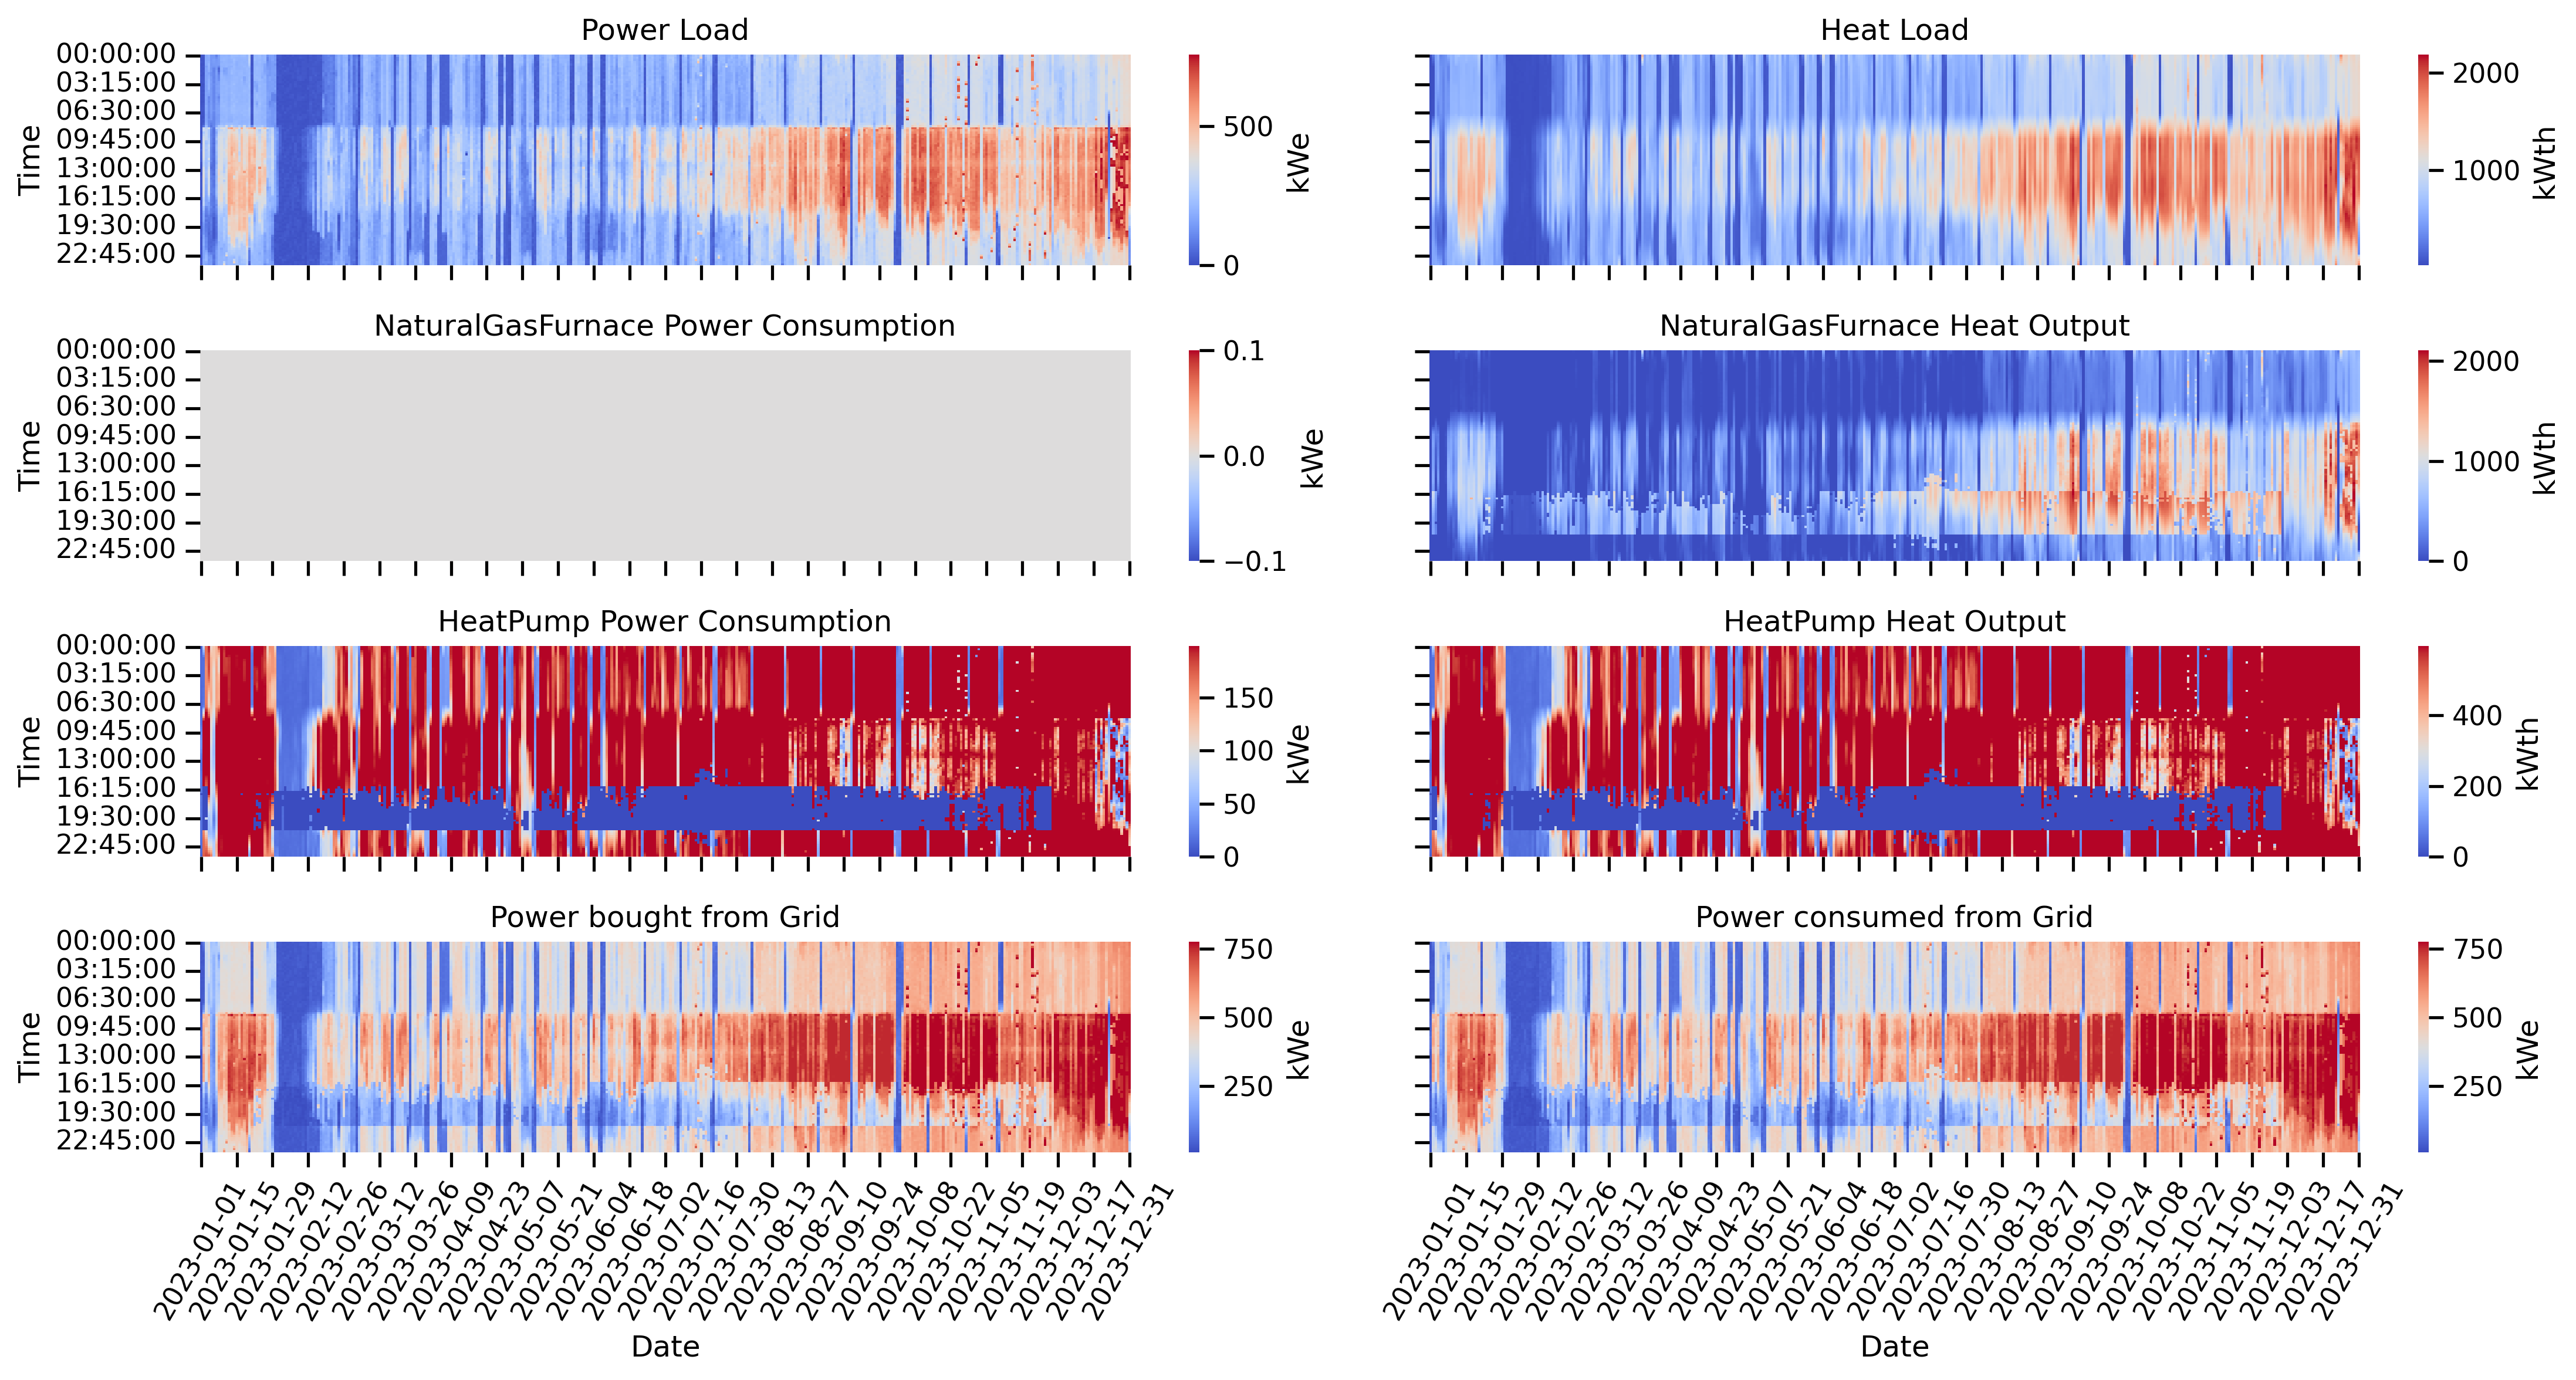

In [11]:
system1.plotHeatmaps();

## Natural Gas and Heat Pump and Battery

In [12]:
lion1 = Battery(
    n_timesteps=n_timesteps,
    dt=1/4,
    capacityPrice=DEFAULT.LION_CAPA_PRICE,
    maxChargeRate=DEFAULT.LION_MAX_CHARGE_RATE,
    effCharge=DEFAULT.LION_EFF_CHARGE,
    effDischarge=DEFAULT.LION_EFF_DISCHARGE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.LION_LIFETIME,
    name="Lithium Ion Battery"
)
system1.addComponent(lion1)
system1.solve(objective="cost", emissionsCap=0.7*baselineEmissions, solver="MOSEK")
system1.describe()

System: baseline
3 component(s)
Component: NaturalGasFurnace
    capacityPrice: 200
    eff: 0.85
    Optimal capacity: 8423.0 kW
Component: HeatPump
    capacityPrice: 1000
    COP: 3
    Optimal capacity: 2730.0 kW
Component: Lithium Ion Battery
    socMin: 0
    socMax: 1
    socInitial: 0.5
    socFinal: 0.5
    maxDischargeRate: 0.25
    maxChargeRate: 0.25
    capacityPrice: 396.75
    effCharge: 0.85
    effDischarge: 0.85
    Optimal energy capacity: 7546.0 kWh
    Optimal power capacity: 1887.0 kW
Status: optimal

Annual power consumption: 16253.0 MWh
Annual gas consumption: 12450.0 MWh
Annual cost: 3.886 M$
Annual emissions: 8.15 MtonCO2
LCOE (Electricity): 0.202 $/kWh
LCOH (Heat): 0.063 $/kWh
Carbon Intensity of Electricity: 0.325 kgCO2/kWhe
Carbon Intensity of Heat: 0.167 kgCO2/kWhth



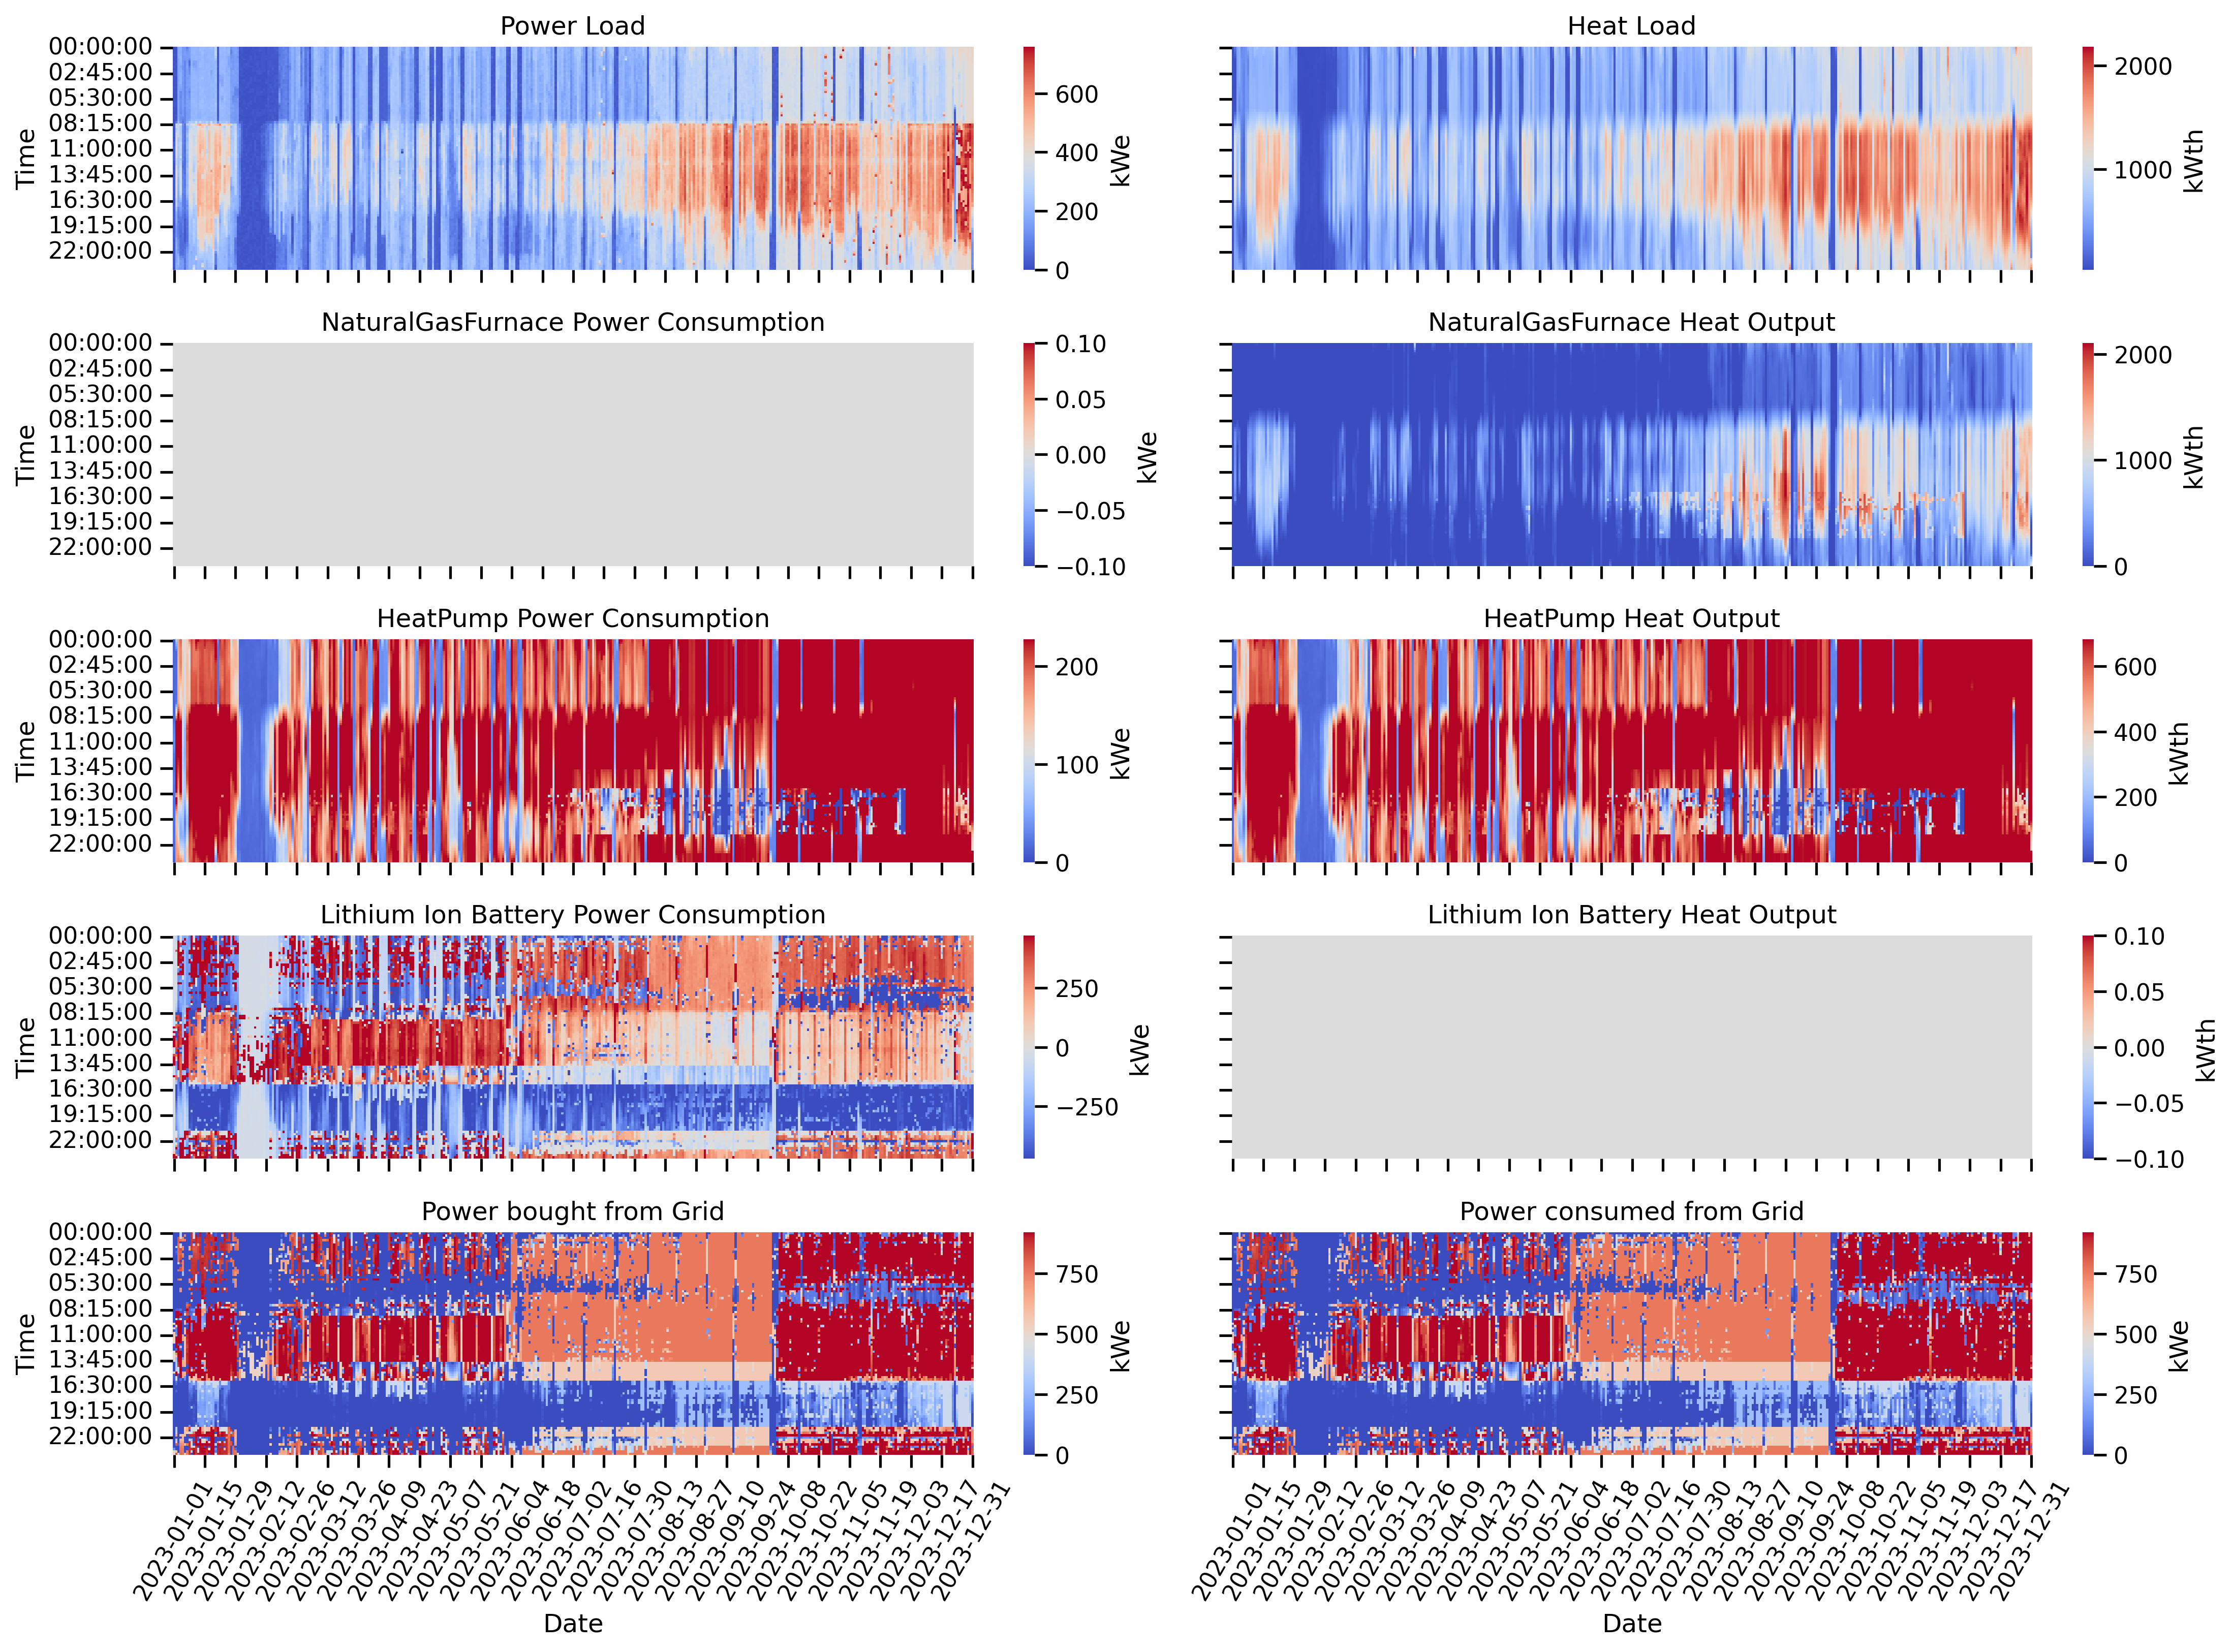

In [13]:
system1.plotHeatmaps();

## Natural Gas and Heat Pump and Battery and Thermal Energy Storage

In [14]:
tes1 = ThermalStorage(
    n_timesteps=n_timesteps,
    dt=1/4,
    capacityPrice=DEFAULT.TES_CAPA_PRICE,
    lossRate=DEFAULT.TES_LOSS_RATE,
    effCharge=DEFAULT.TES_EFF_CHARGE,
    effDischarge=DEFAULT.TES_EFF_DISCHARGE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.TES_LIFETIME
)
system1.addComponent(tes1)
system1.solve(objective="cost", emissionsCap=0.7*baselineEmissions, solver="MOSEK")
system1.describe()

System: baseline
4 component(s)
Component: NaturalGasFurnace
    capacityPrice: 200
    eff: 0.85
    Optimal capacity: 7465.0 kW
Component: HeatPump
    capacityPrice: 1000
    COP: 3
    Optimal capacity: 2718.0 kW
Component: Lithium Ion Battery
    socMin: 0
    socMax: 1
    socInitial: 0.5
    socFinal: 0.5
    maxDischargeRate: 0.25
    maxChargeRate: 0.25
    capacityPrice: 396.75
    effCharge: 0.85
    effDischarge: 0.85
    Optimal energy capacity: 7376.0 kWh
    Optimal power capacity: 1844.0 kW
Component: ThermalStorage
    socMin: 0
    socMax: 1
    socInitial: 0.5
    socFinal: 0.5
    lossRate: 0
    capacityPrice: 200
    effCharge: 1
    effDischarge: 1
    Optimal energy capacity: 746.0 kWh
    Optimal power capacity: 2598.0 kW
Status: optimal

Annual power consumption: 16260.0 MWh
Annual gas consumption: 12425.0 MWh
Annual cost: 3.879 M$
Annual emissions: 8.15 MtonCO2
LCOE (Electricity): 0.202 $/kWh
LCOH (Heat): 0.063 $/kWh
Carbon Intensity of Electricity: 0.325 kgC

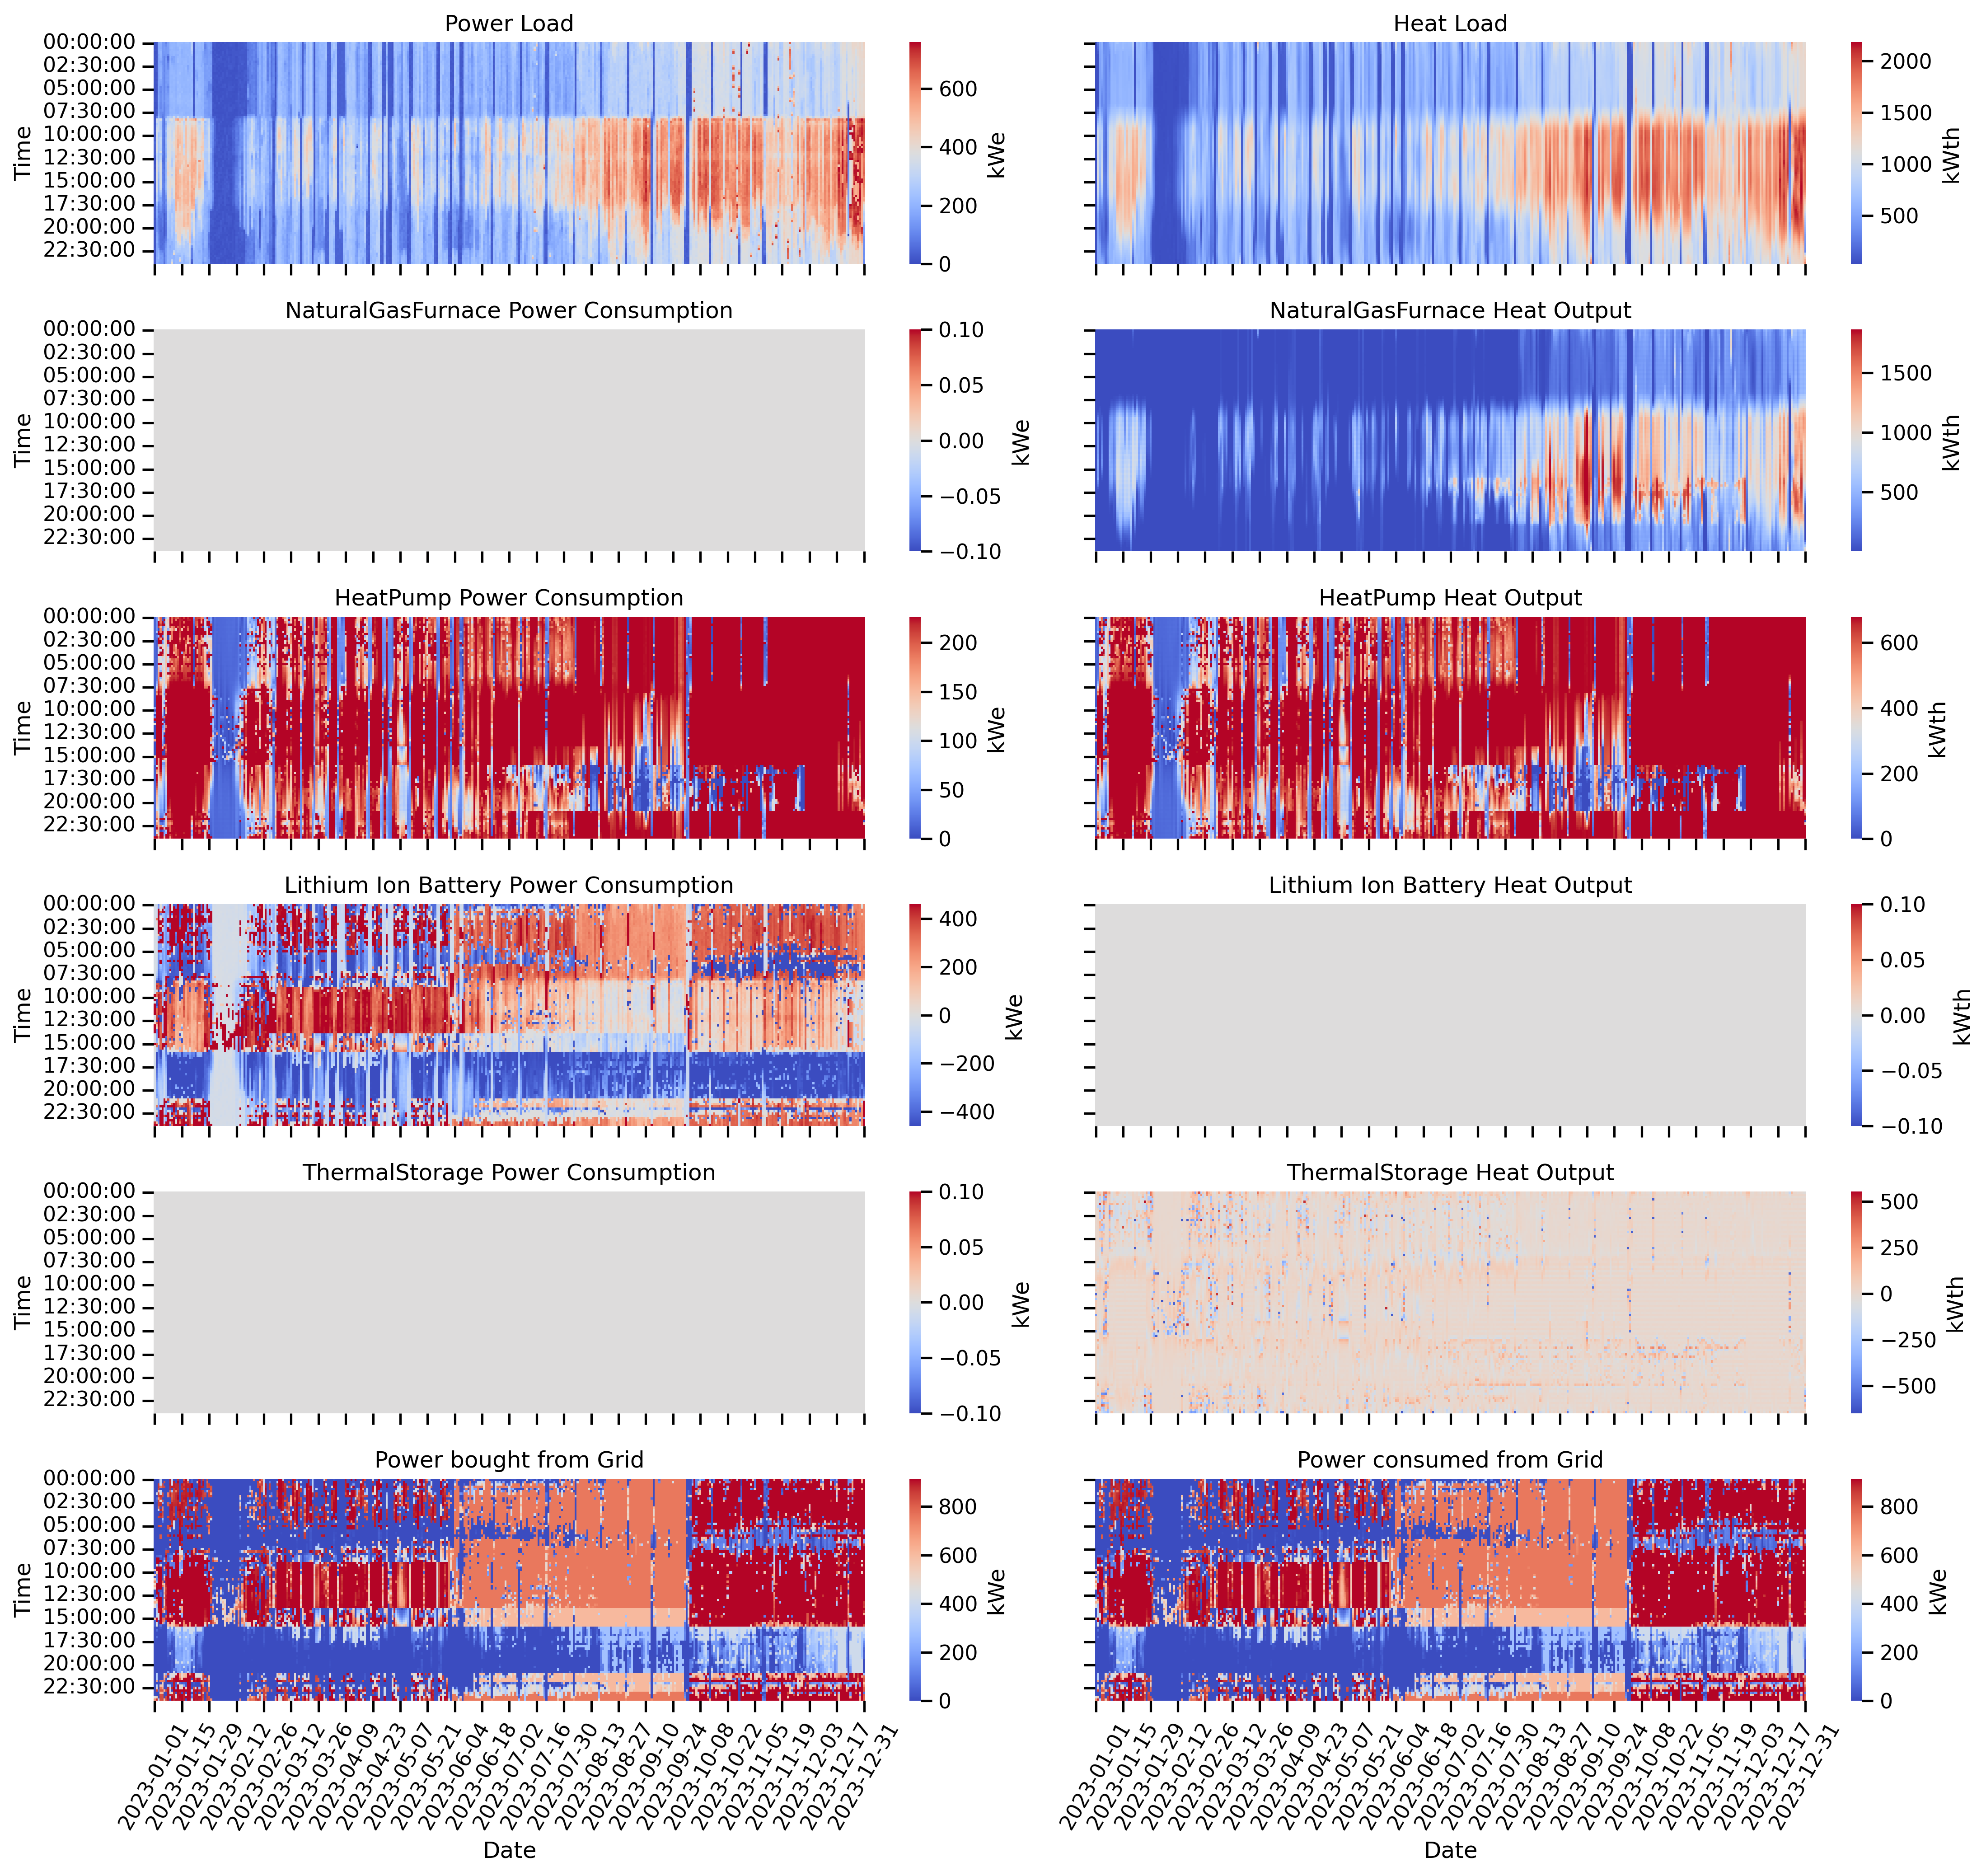

In [15]:
system1.plotHeatmaps();

## Natural Gas and Heat Pump and Battery and Thermal Energy Storage and offsite PV

In [16]:
pvu1 = PVsystem(
    n_timesteps=n_timesteps,
    dt=1/4,
    pvLoadProfile=pvuLoad,
    ppaPrice=DEFAULT.PV_PPA_PRICE,
    averageEmissions=DEFAULT.PV_AVG_EMISSIONS,
    onsite=False
)
system1.addComponent(pvu1)
system1.solve(objective="cost", emissionsCap=0.7*baselineEmissions, solver="MOSEK")
system1.describe()

System: baseline
5 component(s)
Component: NaturalGasFurnace
    capacityPrice: 200
    eff: 0.85
    Optimal capacity: 7162.0 kW
Component: HeatPump
    capacityPrice: 1000
    COP: 3
    Optimal capacity: 1419.0 kW
Component: Lithium Ion Battery
    socMin: 0
    socMax: 1
    socInitial: 0.5
    socFinal: 0.5
    maxDischargeRate: 0.25
    maxChargeRate: 0.25
    capacityPrice: 396.75
    effCharge: 0.85
    effDischarge: 0.85
    Optimal energy capacity: 4990.0 kWh
    Optimal power capacity: 1247.0 kW
Component: ThermalStorage
    socMin: 0
    socMax: 1
    socInitial: 0.5
    socFinal: 0.5
    lossRate: 0
    capacityPrice: 200
    effCharge: 1
    effDischarge: 1
    Optimal energy capacity: 223.0 kWh
    Optimal power capacity: 893.0 kW
Component: PVsystem
    ppaPrice: 0.04
    pvLoadProfile: [0. 0. 0. ... 0. 0. 0.]
    onsite: False
    Optimal power capacity: 3.98 MW
    Annual emissions: 0.24 MtonCO2
Status: optimal

Annual power consumption: 5108.0 MWh
Annual gas consumpt

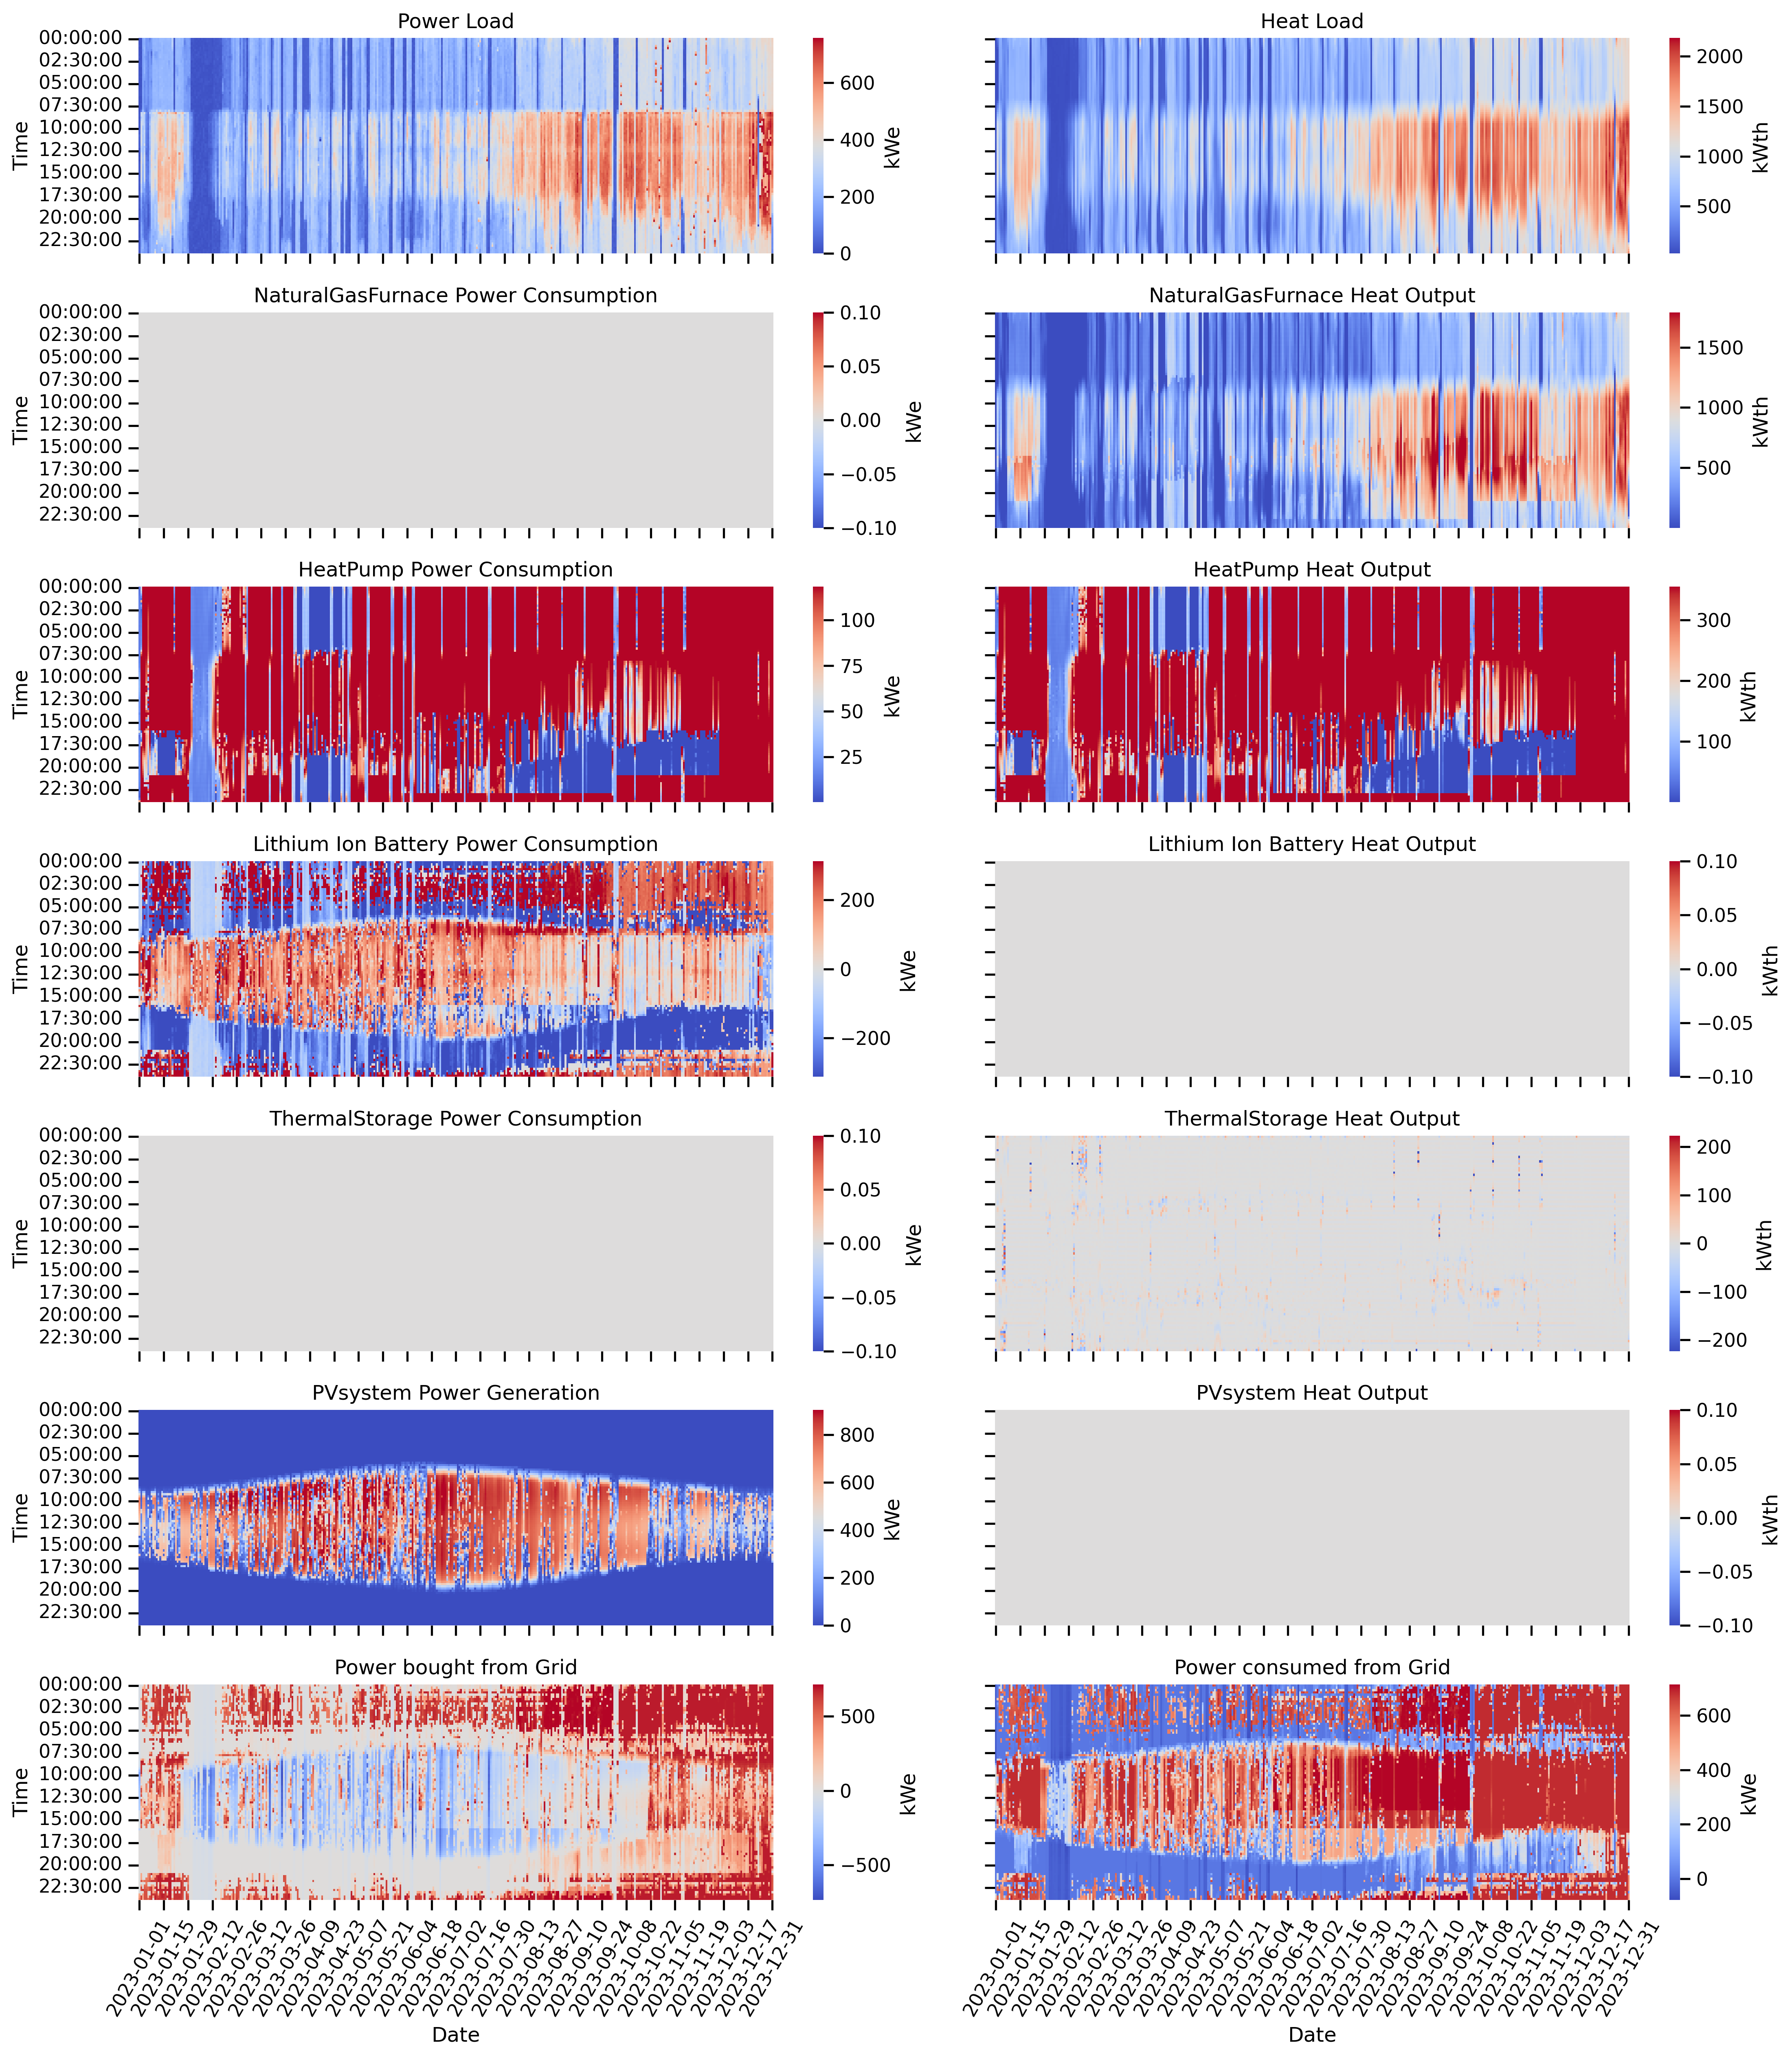

In [17]:
system1.plotHeatmaps();

In [18]:
colors = {'HeatPump': 'C0', 'Power Load': 'C1', 'Lithium Ion Battery': 'C4', 'Total Power Consumption': 'black', 'PVsystem': 'C2', '':'C4',
          'NaturalGasFurnace' : 'C5', 'Heat Load': 'C3', 'ThermalStorage': 'C4', 'Total Heat Consumption': 'black',
          'Marginal Power Price': 'C3', 'Marginal Power Emissions': 'C5'}
# empty string is for the battries when negative

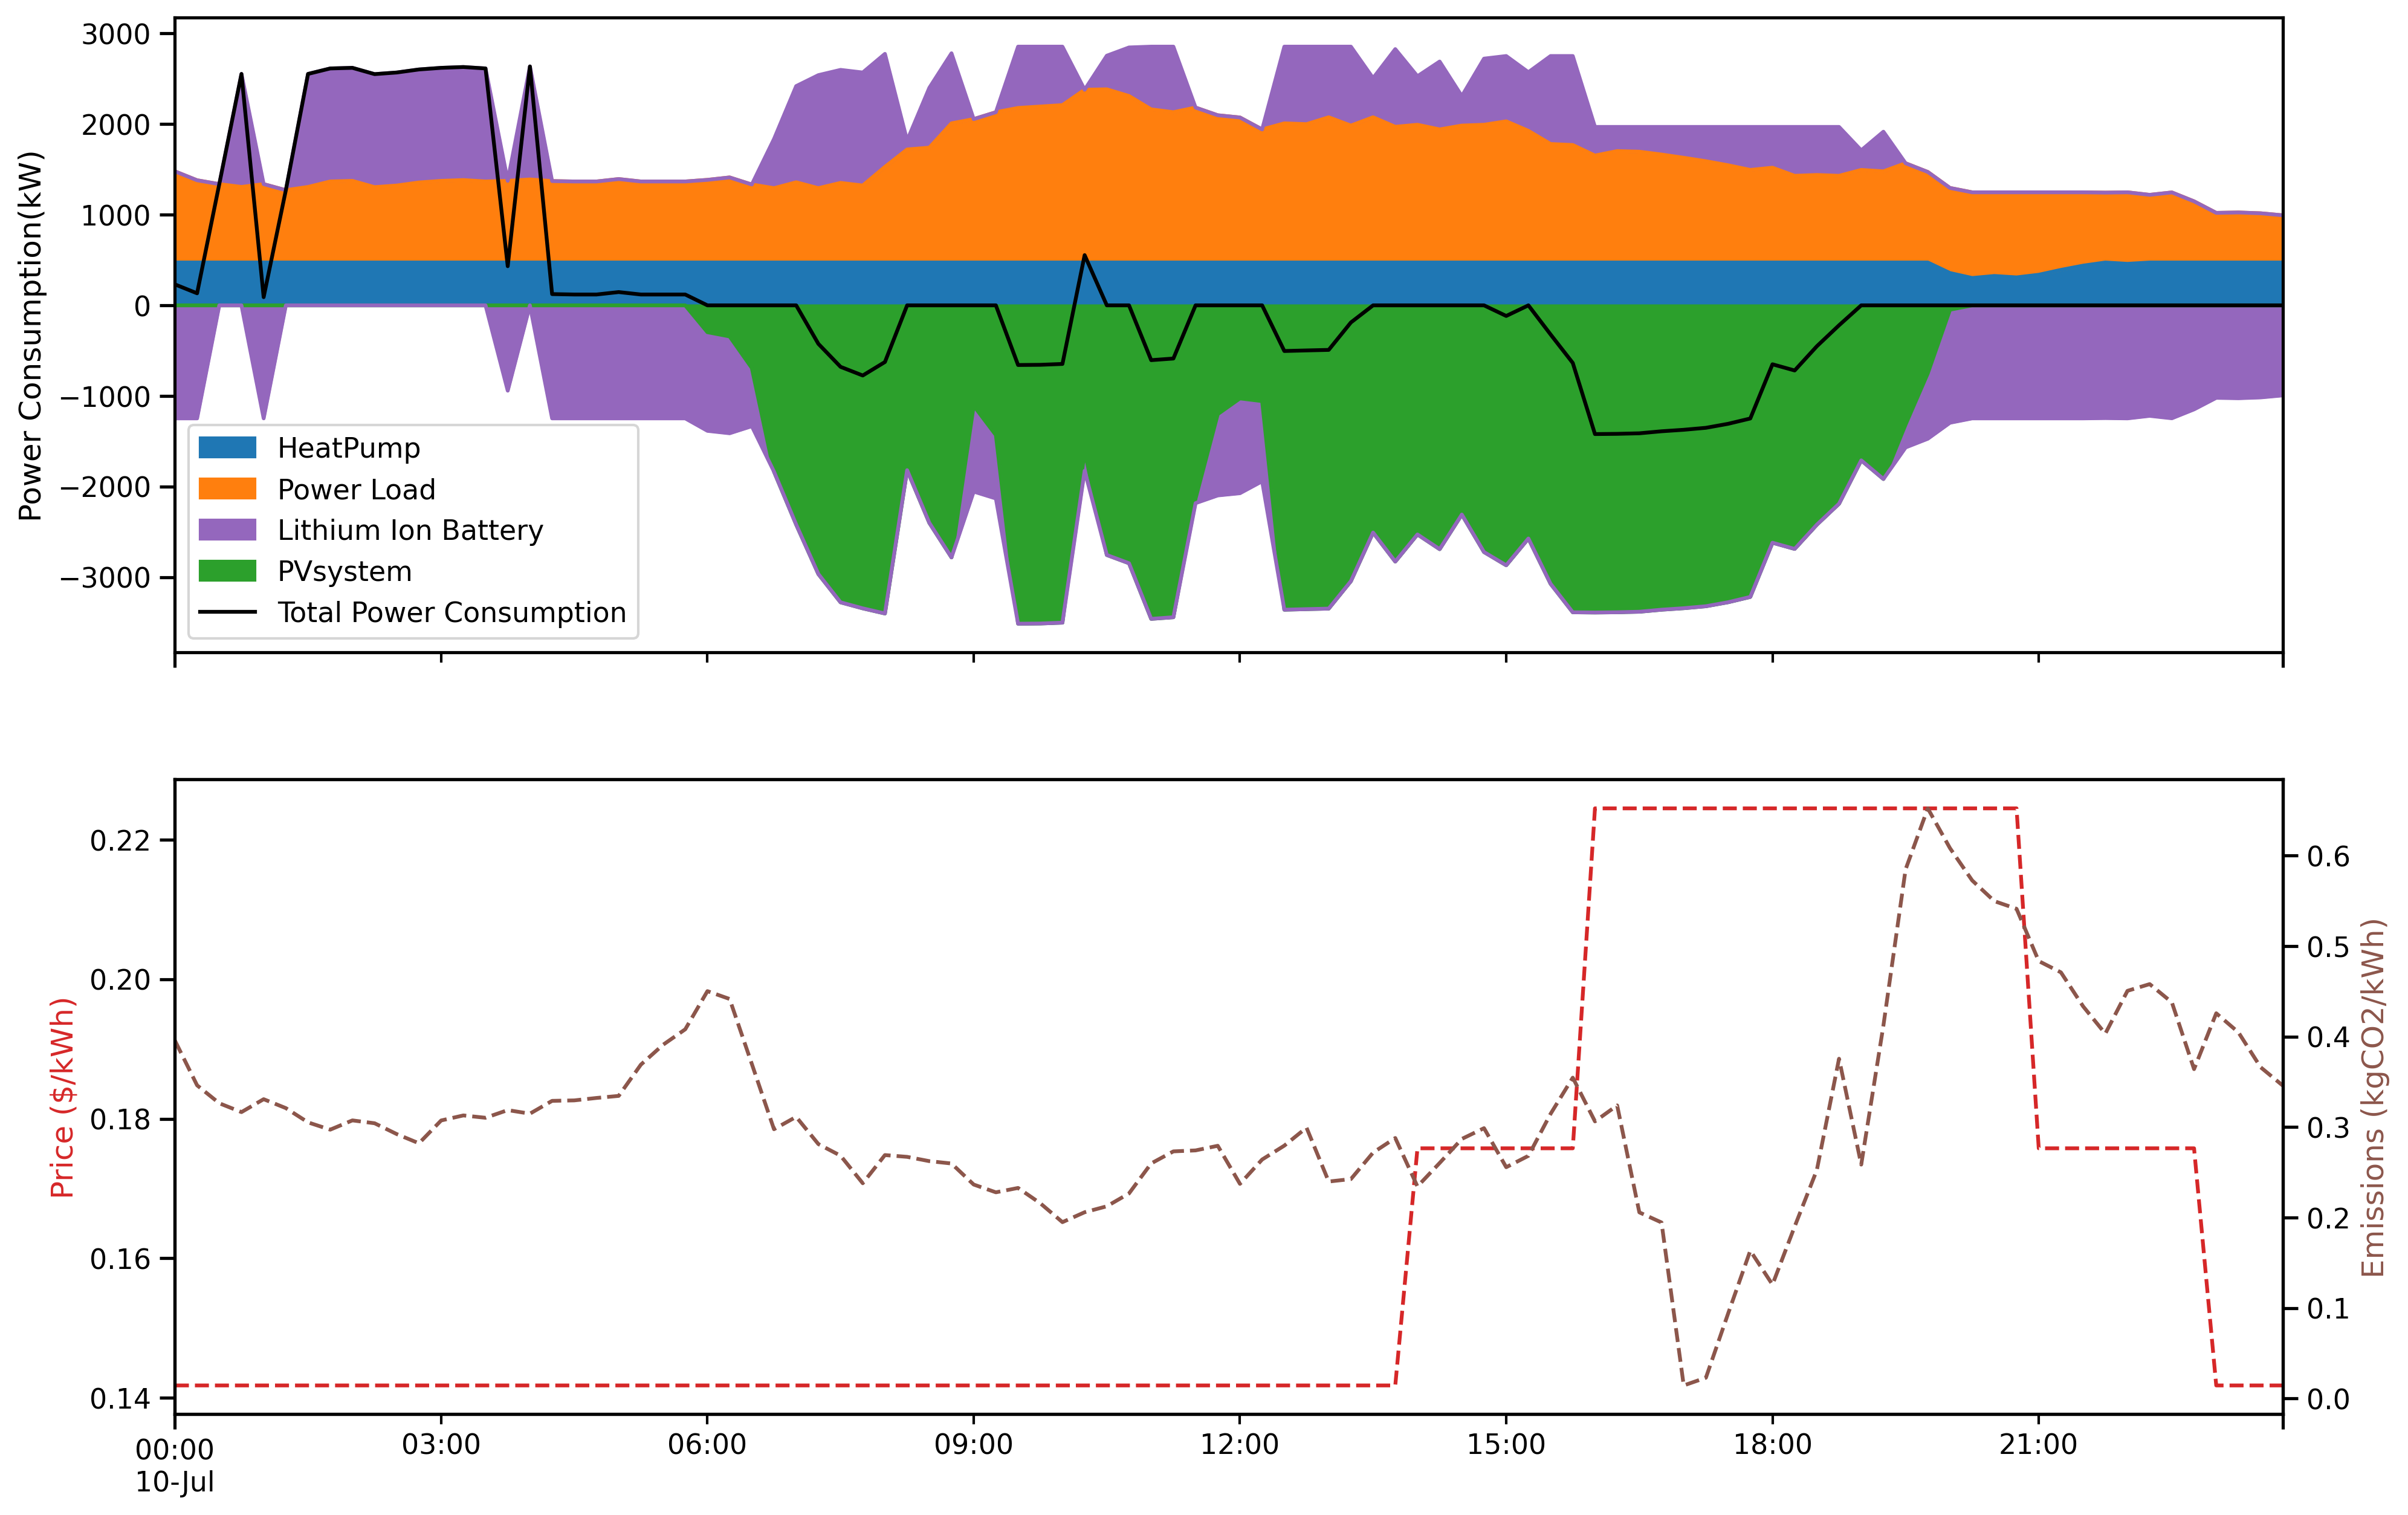

In [19]:
powerConsumers = ['HeatPump', 'Power Load']
powerStorage = ['Lithium Ion Battery']
powerGenerators = ['PVsystem']
system1.plot_power(colors, powerConsumers, powerStorage, powerGenerators, '2023-07-10');

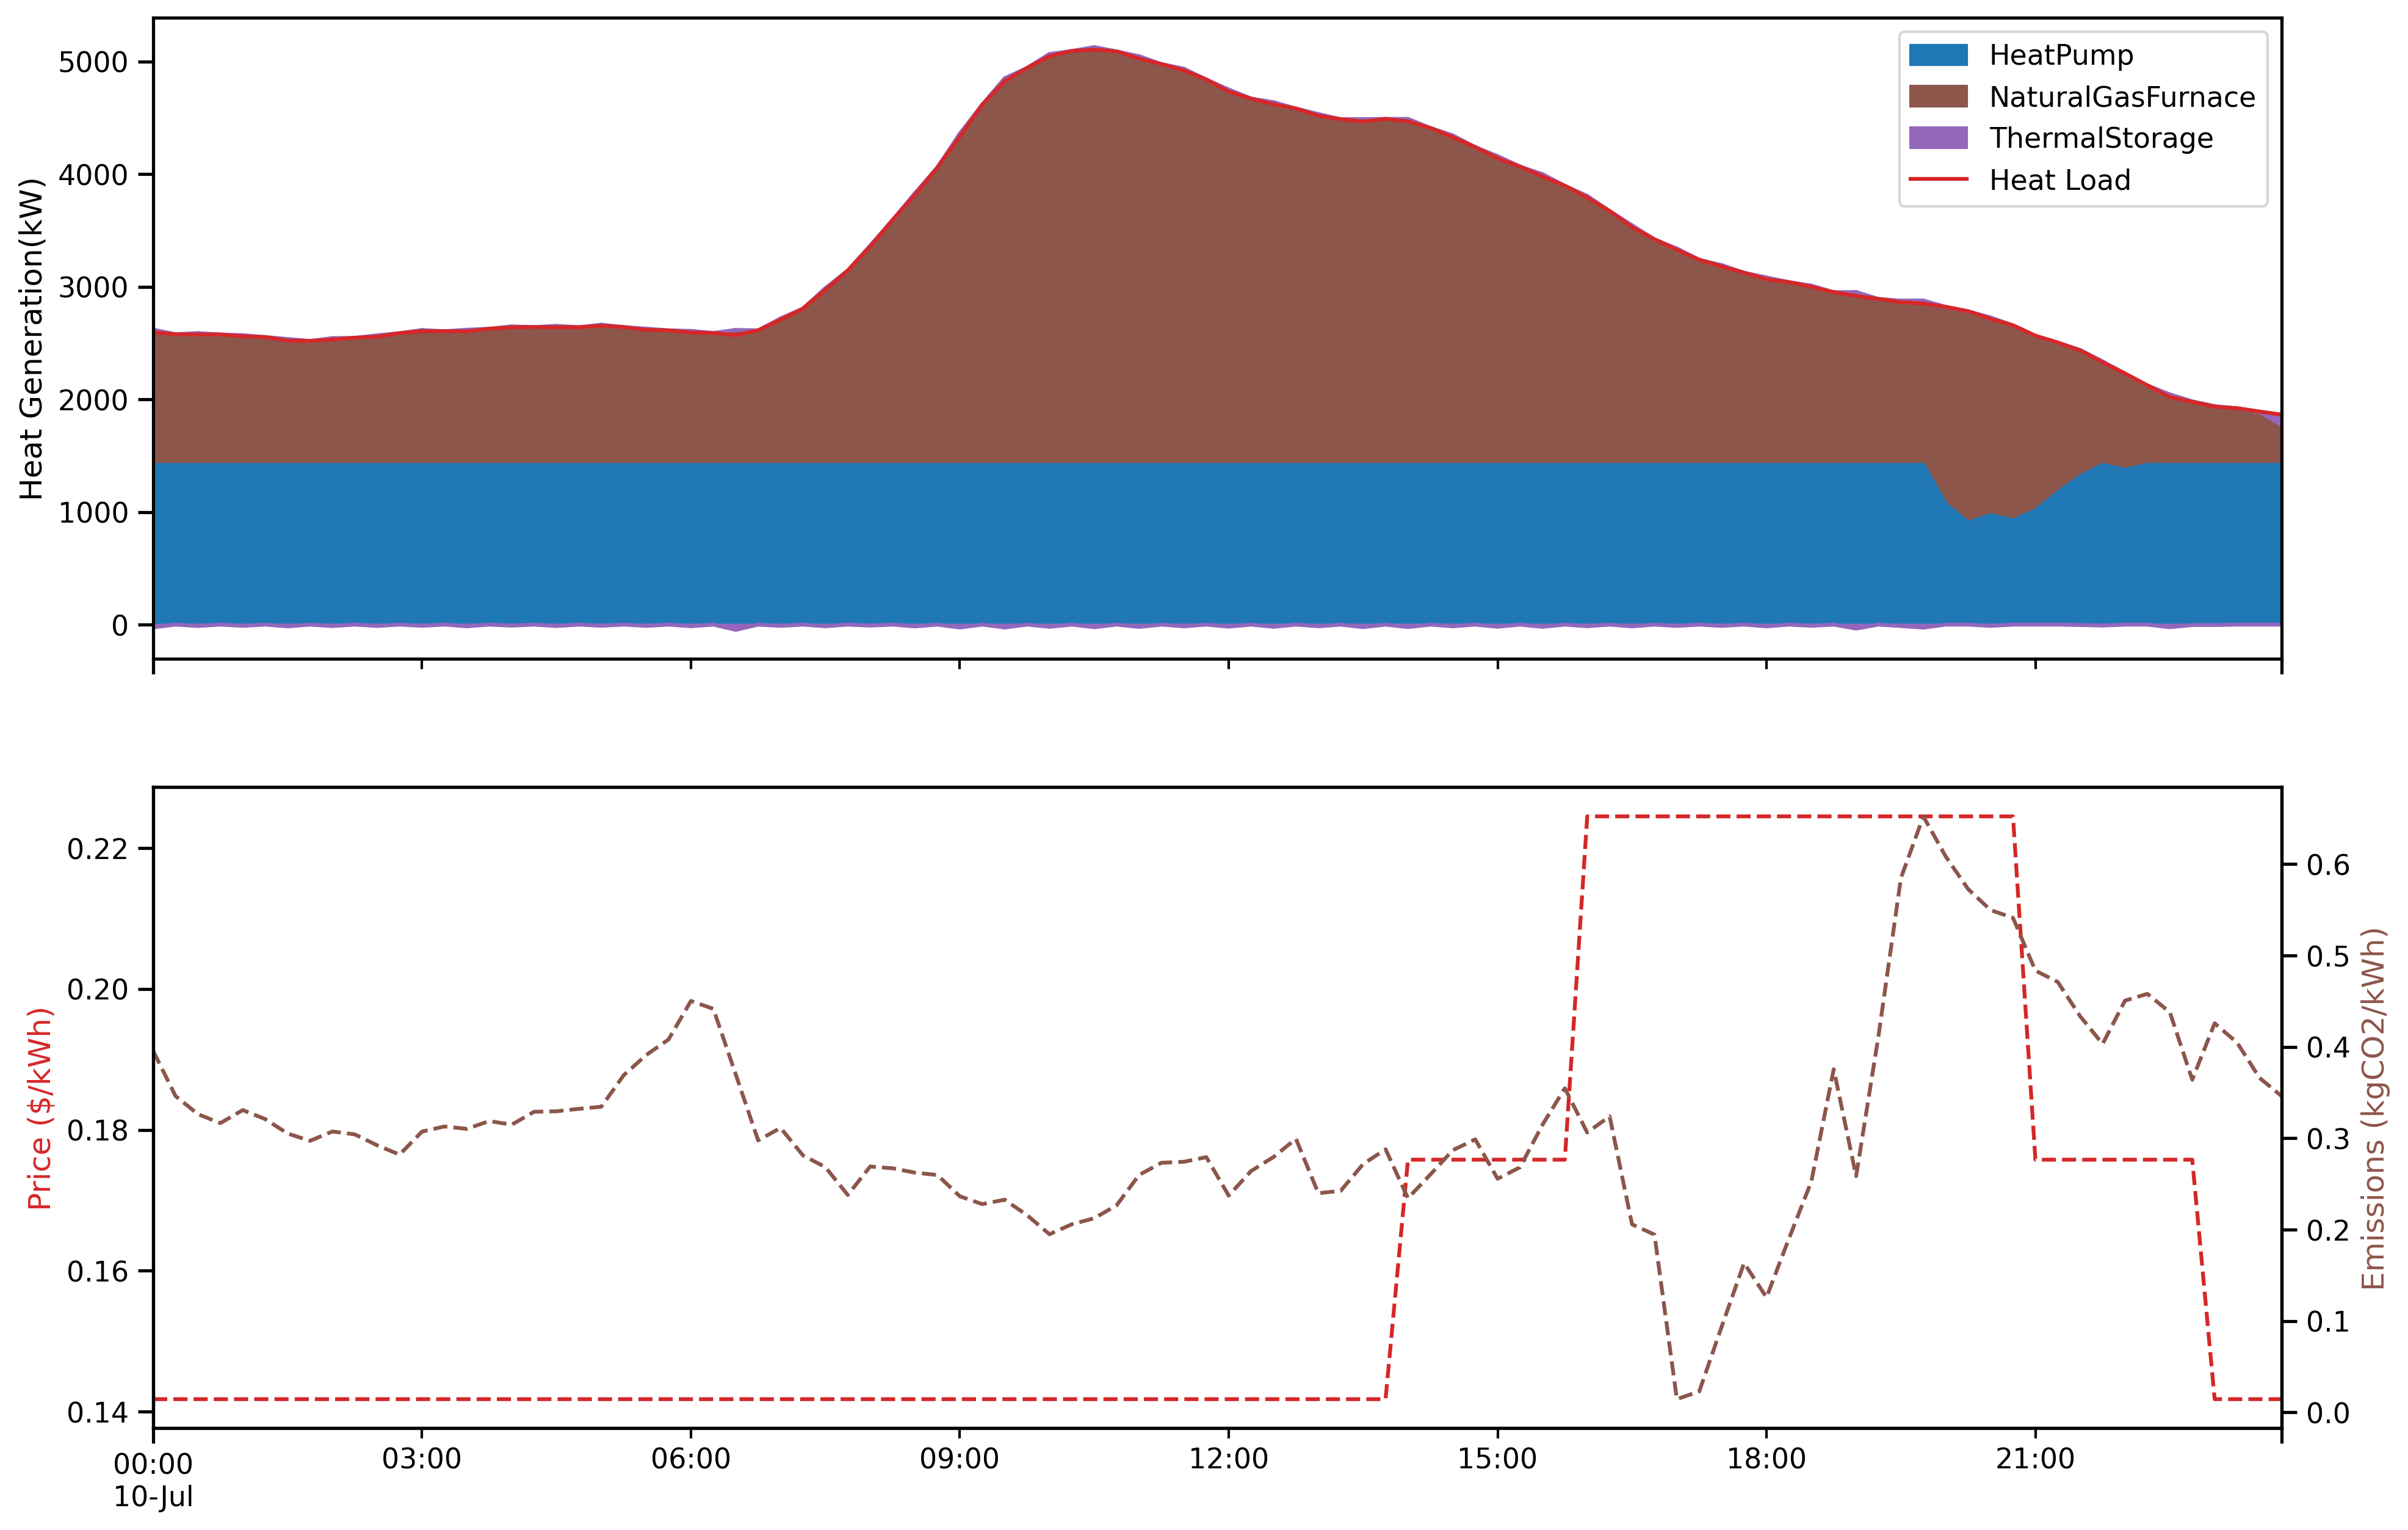

In [20]:
heatGenerators = ['HeatPump', 'NaturalGasFurnace']
heatStorage = ['ThermalStorage']
test = system1.plot_heat(colors, heatGenerators, heatStorage, '2023-07-10')

In [22]:
print(f"Heat Pump load factor: {np.round(100 * np.sum(hp1.heatOutput.value) / (hp1._variablesDict['capacity'].value*8760), 2)} %")

Heat Pump load factor: 76.09 %
